Source: https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from ipywidgets import interact, interactive
from sklearn.cluster import KMeans
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from loader import load_exam

In [100]:
data_path = '../data/example_7/'
patient, imgs = load_exam(data_path)

In [101]:
print("Slice Thickness: %f" % patient[0].SliceThickness)
print("Pixel Spacing (row, col): (%f, %f) " % (patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]))

Slice Thickness: 1.000000
Pixel Spacing (row, col): (0.574219, 0.574219) 


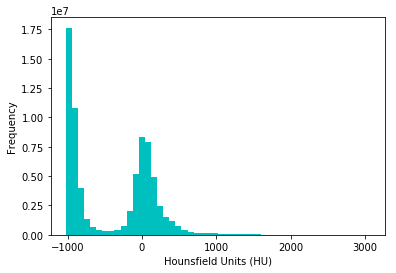

In [102]:
plt.hist(imgs.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

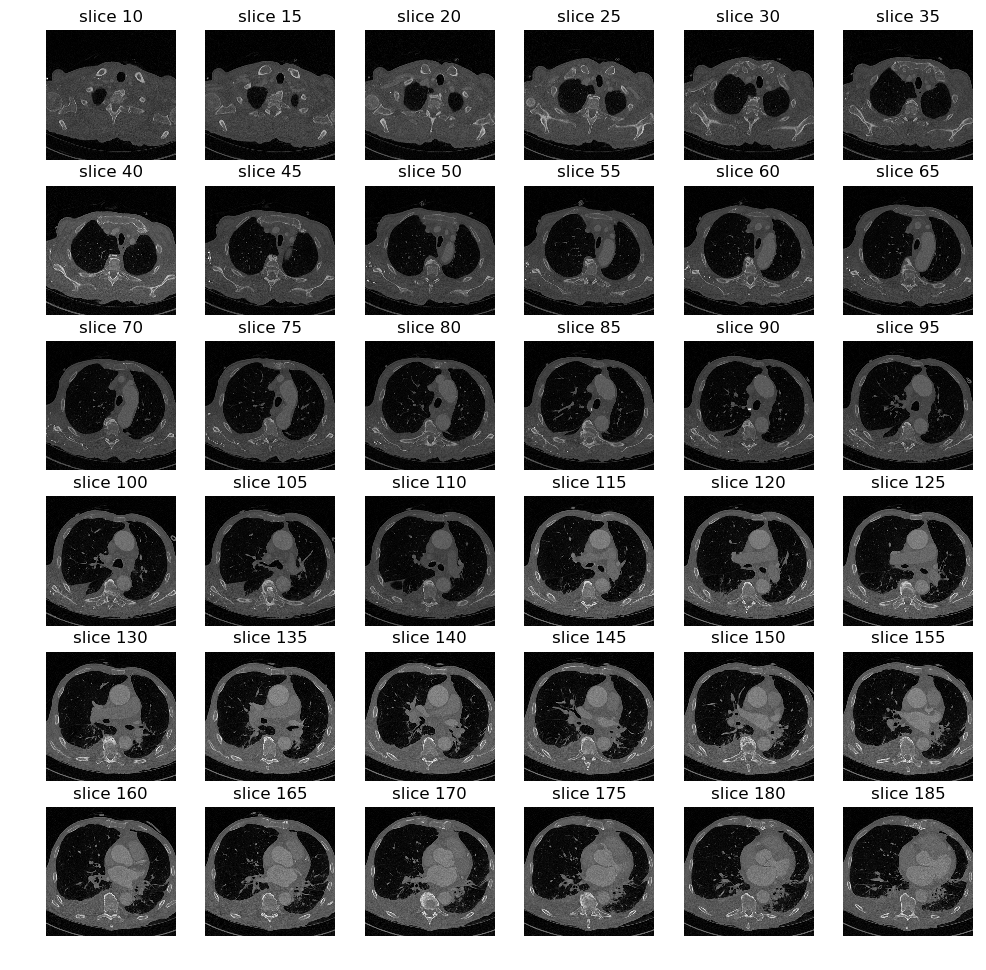

In [103]:
def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=5):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12],dpi=100)
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs)

In [104]:
imgs.shape, "<br>", imgs[0], "<br>", type(imgs[0])

((277, 512, 512),
 '<br>',
 array([[-1023,  -953,  -967, ..., -1007,  -972,  -893],
        [-1023,  -972,  -977, ...,  -997,  -916,  -916],
        [-1022,  -987,  -977, ...,  -932,  -992, -1024],
        ...,
        [ -934,  -969,  -904, ...,  -936,  -948,  -934],
        [ -942,  -908,  -870, ...,  -926,  -937,  -940],
        [ -970,  -960, -1019, ...,  -887,  -921,  -931]], dtype=int16),
 '<br>',
 numpy.ndarray)

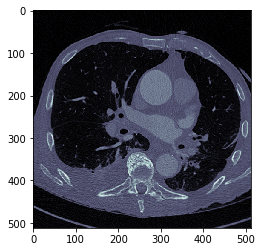

In [105]:
plt.imshow(imgs[150],cmap="bone")

In [106]:
def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    orig_img = img.copy()
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([1,1])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='bone')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='bone')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='bone')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='bone')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='bone')
        ax[2, 1].axis('off')
        
        plt.show()
    # change to original implementation, 
    # we want hu field values back in the returned images
    return mask*orig_img

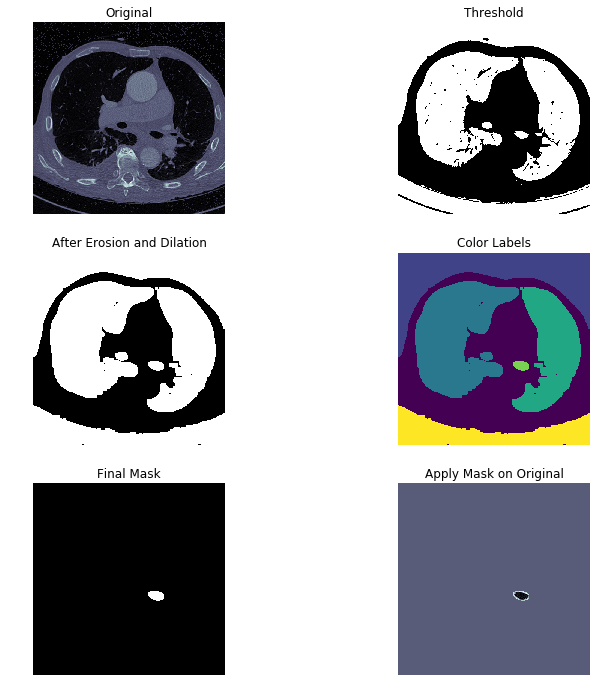

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [107]:
a = imgs[130].copy()
make_lungmask(a, display=True)

In [108]:
masked_lung = []

for img in imgs:
    masked_lung.append(make_lungmask(img))

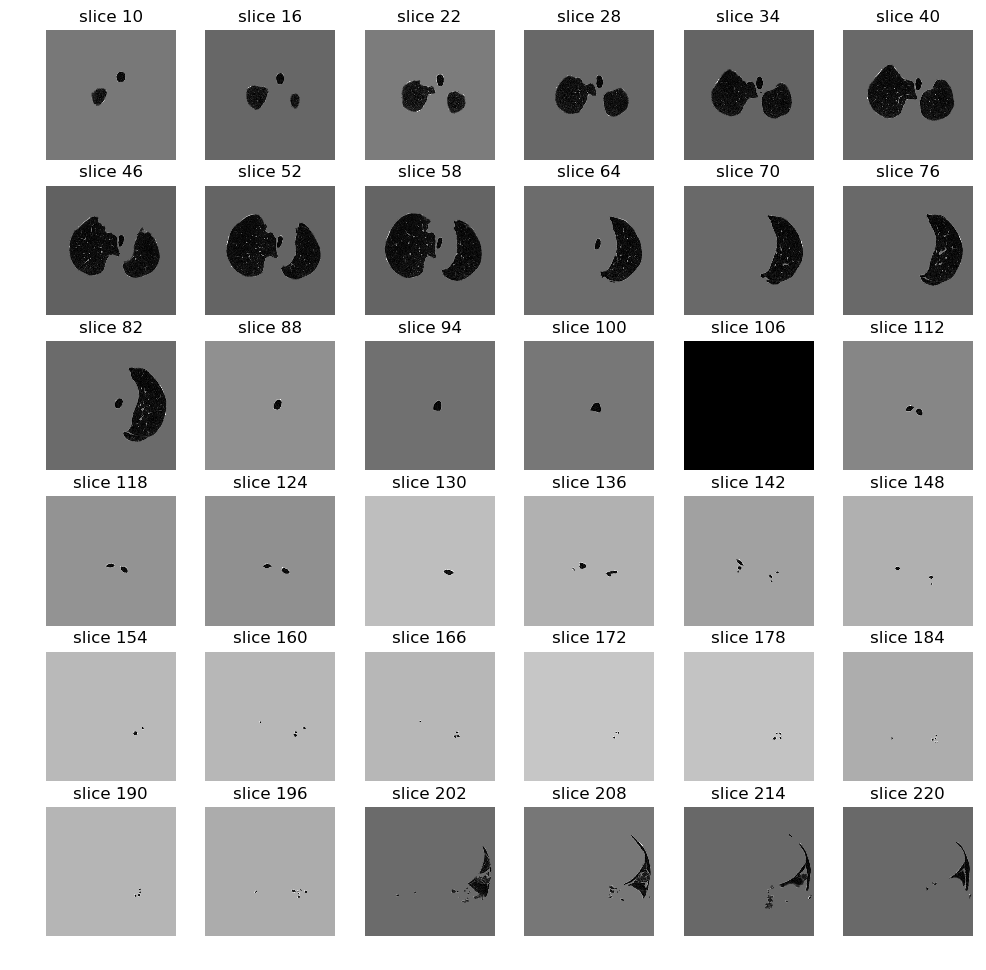

In [109]:
sample_stack(masked_lung, show_every=6)

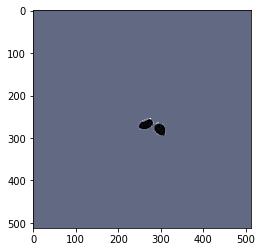

In [110]:
plt.imshow(masked_lung[109], cmap='bone')

In [111]:
MAX_HU_LUNG= -380
MIN_HU_LUNG= -1500
lung_voxels = sum([np.count_nonzero(i*((i >= MIN_HU_LUNG) & (i <= MAX_HU_LUNG))) for i in masked_lung])
print('Lung voxel count is: {}'.format(lung_voxels))

Lung voxel count is: 2664265


In [112]:
x, y, z = patient[0].PixelSpacing[0], patient[0].PixelSpacing[1], patient[0].SliceThickness
voxel_volume = x * y * z
print('Voxel volume is {}'.format(voxel_volume))

Voxel volume is 0.3297271728515625


In [113]:
lung_volume = lung_voxels * voxel_volume
volume = round(lung_volume/1000.0)/1000.0
print('Lung volume is {}L'.format(volume))

Lung volume is 0.878L


Now the PD 15 value

In [114]:
stacked = np.stack([i*((i >= MIN_HU_LUNG) & (i <= MAX_HU_LUNG)) for i in masked_lung])
stacked.shape

(277, 512, 512)

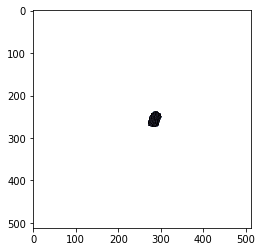

In [115]:
plt.imshow(stacked[90], cmap='bone')

In [116]:
hu_values = stacked.ravel()[np.flatnonzero(stacked)]
len(hu_values)

2664265

In [117]:
percentile = 15
rank = int(len(pp) * percentile / 100)

In [118]:
print('PD 15 value is: {}'.format(hu_values[rank]))

PD 15 value is: -727


In [119]:
format: lambda x: "{:,}".format(x).replace(",", "'")

In [120]:
LAAS = [-950, -900, -850]
for i in LAAS:
    count = len(hu_values[hu_values <= i])
    print(str(i), "{:,}".format(count).replace(",", "'"), count * voxel_volume)

-950 494'956 163200.44256591797
-900 1'115'064 367666.9002685547
-850 1'712'677 564716.1452178955
